In [1]:
import wget
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np
IMG_SHAPE = (28,28)

In [3]:
url = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz'
file_d = wget.download(url)

100% [......................................................] 8458043 / 8458043

In [4]:
import tarfile
def untar(fname):
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname)
        tar.extractall()
        tar.close()
        print("Extracted in Current Directory")
    else:
        print("Not a tar.gz file: '%s '" % sys.argv[0])
 

In [6]:
untar(file_d)

Extracted in Current Directory


In [2]:
import os
from scipy.misc import imread,imresize

In [4]:
styles = os.listdir('./notMNIST_small/B/')
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

dictt = {s:i for i,s in enumerate(styles)}
dicttt = {c:i for i,c in enumerate(classes)}

In [5]:
data = []

labels = []

for letter in classes:
    for path in os.listdir(os.path.join('./notMNIST_small/', letter)):
        path0 = os.path.join('./notMNIST_small/', letter, path)
        try:
            data.append(imresize(imread(path0),IMG_SHAPE))
        except:
            print("failed: {}".format(path0))
        else: 
            labels.append([dicttt[letter], dictt[path]])

data = np.stack(data)[:,None]
data = data.astype(np.float32)
data = (data - np.mean(data))/np.std(data)/16.
labels = np.array(labels)


failed: ./notMNIST_small/A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
failed: ./notMNIST_small/F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


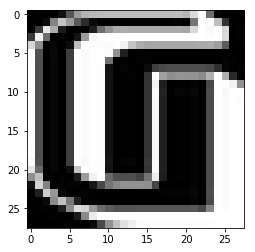

In [6]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0]),0], cmap="gray", interpolation="none")

In [7]:
lab0 = np.zeros((labels.shape[0], len(np.unique(labels[:,0]))))
lab0[np.arange(lab0.shape[0]), labels[:,0]] += 1

lab1 = np.zeros((labels.shape[0], len(np.unique(labels[:,1]))))
lab1[np.arange(lab1.shape[0]), labels[:,1]] += 1


### Generator trained with l2_loss

In [8]:
import theano 
import theano.tensor as T
import lasagne

In [9]:
class_input = T.matrix("letter")
style_input = T.matrix("font style")
image_input = T.tensor4("true image")

In [10]:
DIM_LETTER = lab0.shape[1]
DIM_STYLE = lab1.shape[1]
#neural network

l_in_letter = lasagne.layers.InputLayer((None, DIM_LETTER), input_var=class_input)
l_dense_letter = lasagne.layers.DenseLayer(l_in_letter, 768, nonlinearity=lasagne.nonlinearities.rectify)

l_in_style = lasagne.layers.InputLayer((None, DIM_STYLE), input_var=style_input)

l_dense_style = lasagne.layers.DenseLayer(l_in_style, 768, nonlinearity=lasagne.nonlinearities.rectify)

l_concat = lasagne.layers.concat([l_dense_letter, l_dense_style])

l_dense1 = lasagne.layers.DenseLayer(l_concat, 1024, nonlinearity=lasagne.nonlinearities.leaky_rectify)

l_dense2 = lasagne.layers.DenseLayer(l_dense1, 128*8*8)

l_reshape = lasagne.layers.ReshapeLayer(l_dense2, ([0], 128, 8, 8))

l_upscale1 = lasagne.layers.Upscale2DLayer(l_reshape, scale_factor=2, mode='dilate')

l_upconv1 = lasagne.layers.Conv2DLayer(l_upscale1, 64, 3, pad='same')

#l_upconv1 = lasagne.layers.TransposedConv2DLayer(l_reshape, 64, 3, stride=2, crop='same')

l_conv1 = lasagne.layers.Conv2DLayer(l_upconv1, 64, 3, pad='same')

l_upscale2 = lasagne.layers.Upscale2DLayer(l_conv1, scale_factor=2, mode='dilate')

l_upconv2 = lasagne.layers.Conv2DLayer(l_upscale2, 32, 3, pad='same')

#l_upconv2  = lasagne.layers.TransposedConv2DLayer(l_conv1, 32, 3, stride = 2, crop = 'same')

l_conv2 = lasagne.layers.Conv2DLayer(l_upconv2, 1, 5, nonlinearity=None)

nn = l_conv2



In [11]:
lr = 1e-3

In [12]:
im_gen = lasagne.layers.get_output(nn)

loss = lasagne.objectives.squared_error(im_gen, image_input).mean()

params = lasagne.layers.get_all_params(nn, trainable = True)

updates = lasagne.updates.adam(loss, params, learning_rate=lr)


In [13]:
train_func = theano.function([class_input, style_input, image_input], loss, updates=updates)
val_func = theano.function([class_input, style_input, image_input], loss)
gen_func = theano.function([class_input, style_input], im_gen)

In [14]:
def iterate_minibatches(input0, input1, input2, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(input0))
        np.random.shuffle(indices)
    for start_idx in range(0, len(input0) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield input0[excerpt], input1[excerpt], input2[excerpt]

In [16]:
np.random.seed(1)
indices = np.arange(len(data))
np.random.shuffle(indices) 

In [17]:
data = data[indices]
lab0 = lab0[indices]
lab1 = lab1[indices]

In [18]:
x0_train = lab0[:15000]
x1_train = lab1[:15000]
y_train = data[:15000]

x0_val = lab0[15000:]
x1_val = lab1[15000:]
y_val = data[15000:]

In [22]:
epochs = 10
batch_size = 100
for epoch in range(epochs):
    for c, s, i in iterate_minibatches(x0_train, x1_train, y_train, batchsize=batch_size):
        train_loss = train_func(c,s,i)
    test_loss = val_func(x0_val, x1_val, y_val)
    print('After epoch {0}, train loss is {1} and val loss is {2}'.format(epoch, train_loss, test_loss))

After epoch 0, train loss is 0.0018980224339393544 and val loss is 0.0018860091322047538
After epoch 1, train loss is 0.001397233063349004 and val loss is 0.001420650913963026
After epoch 2, train loss is 0.0012241262820426994 and val loss is 0.001226980376543936
After epoch 3, train loss is 0.0008241391007330655 and val loss is 0.0011500175354980625
After epoch 4, train loss is 0.0007597121403386504 and val loss is 0.001110074249958655
After epoch 5, train loss is 0.0007334863261052868 and val loss is 0.0011012481650357361
After epoch 6, train loss is 0.0007084780470912889 and val loss is 0.0010705492738234213
After epoch 7, train loss is 0.0006756641821311417 and val loss is 0.0010704195691774584
After epoch 8, train loss is 0.0005354468037123501 and val loss is 0.0010660170782384121
After epoch 9, train loss is 0.00039688452493441133 and val loss is 0.0010730094124733005


In [23]:
result = gen_func(x0_val, x1_val)

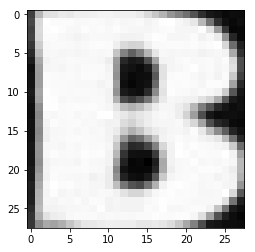

In [24]:
plt.imshow(result[71,0], cmap="gray", interpolation="none")

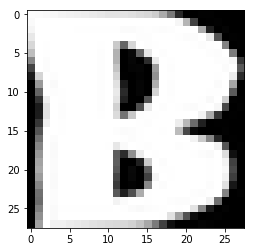

In [25]:
plt.imshow(y_val[71 ,0], cmap="gray", interpolation="none")

In [26]:
# letter B with style #1000
code0 = np.zeros((1, len(classes)))
code0[0, 1] += 1

code1 = np.zeros((1, len(styles)))
code1[0, 999] += 1

code11 = np.zeros((1, len(styles)))
code11[0, 399] += 1


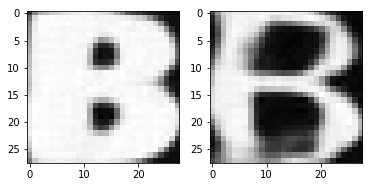

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(gen_func(code0, code1)[0, 0], cmap = "gray", interpolation=None)

plt.subplot(1, 2, 2)
plt.imshow(gen_func(code0, code11)[0, 0], cmap = "gray", interpolation=None)

In [39]:
#with style 1000 + 500
code1 = np.zeros((1, len(styles)))
code1[0, 999] += 1
code1[0, 399] += 1

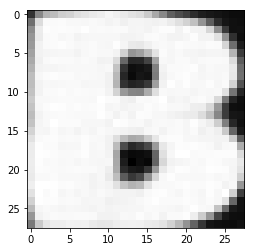

In [28]:
plt.imshow(gen_func(code0, code1)[0, 0], cmap = "gray", interpolation=None)

In [29]:
np.random.seed()
def plot_gallery(letter = 'A', n_row=3, label = None, random = False, indices = None, style = True):
    """Helper function to plot a gallery of letters"""
    ind = dicttt[letter]
    code0 = np.zeros((1, len(classes)))
    code0[:, ind] += 1
    if indices == None:
        indices = np.random.randint(len(styles), size= n_row)
    if label != None:
        print(label)
    plt.figure(figsize=(1.5 * n_row, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for num0, i in enumerate(indices):
        for num1, j in enumerate(indices):
            code1 = np.zeros((1, len(styles)))
            code1[:, i] += 0.5
            code1[:, j] += 0.5
            plt.subplot(n_row, n_row, num0*n_row + num1 + 1)
            if random == False :
                plt.imshow(gen_func(code0, code1)[0, 0], cmap = "gray", interpolation=None, label = 'style #' + str(i))
            else:
                if style:
                    noise = np.random.rand(1, DIM_NOISE)
                    plt.imshow(gen_func1(code0, code1, noise)[0, 0], cmap = "gray", interpolation=None)
                else:
                    noise = np.random.rand(1, DIM_NOISE)
                    plt.imshow(gen_func2(code0, noise)[0,0], cmap="gray", interpolation=None)

            plt.xticks(())
            plt.yticks(())
            #plt.yticks(np.arange(n_row), indices, rotation = 45)

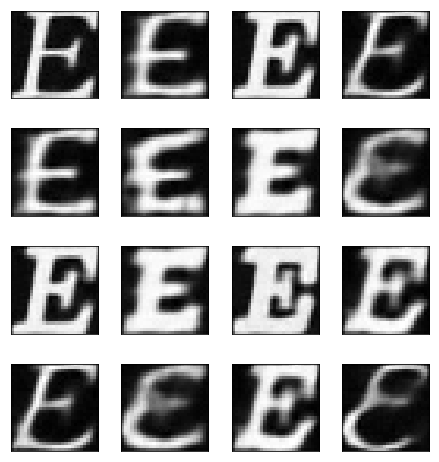

In [64]:
plot_gallery('E', n_row = 4)

In [31]:
import pickle
all_params = lasagne.layers.get_all_param_values(nn, trainable=True)
output = open('second.pkl', "wb")
pickle.dump(all_params, output)
output.close()
#updates = lasagne.updates.adam(loss, params, learning_rate=0.01)
#train_fn = theano.function([input_X], loss, updates=updates)
#lasagne.layers.set_all_param_values(l_output)

In [56]:


def display_letter(letter, styles):
    let = dicttt[letter]
    code0 = np.zeros((1, DIM_LETTER))
    code0[0, let] += 1
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i, style in enumerate(styles):
        s = dictt[style]
        code1 = np.zeros((1, DIM_STYLE))
        code1[0, s] += 1
        plt.subplot(4, 5, i + 1)
        plt.imshow(gen_func(code0, code1)[0, 0], cmap = "gray", interpolation=None)
        plt.xticks(())
        plt.yticks(())

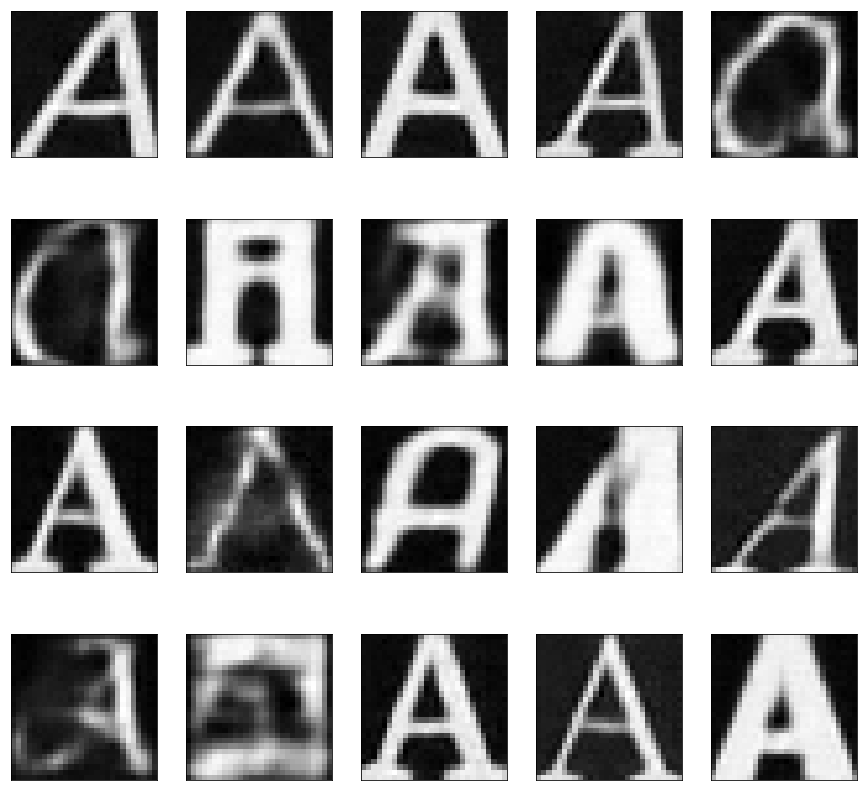

In [58]:
st = np.random.choice(styles, 20)
display_letter('A', st)

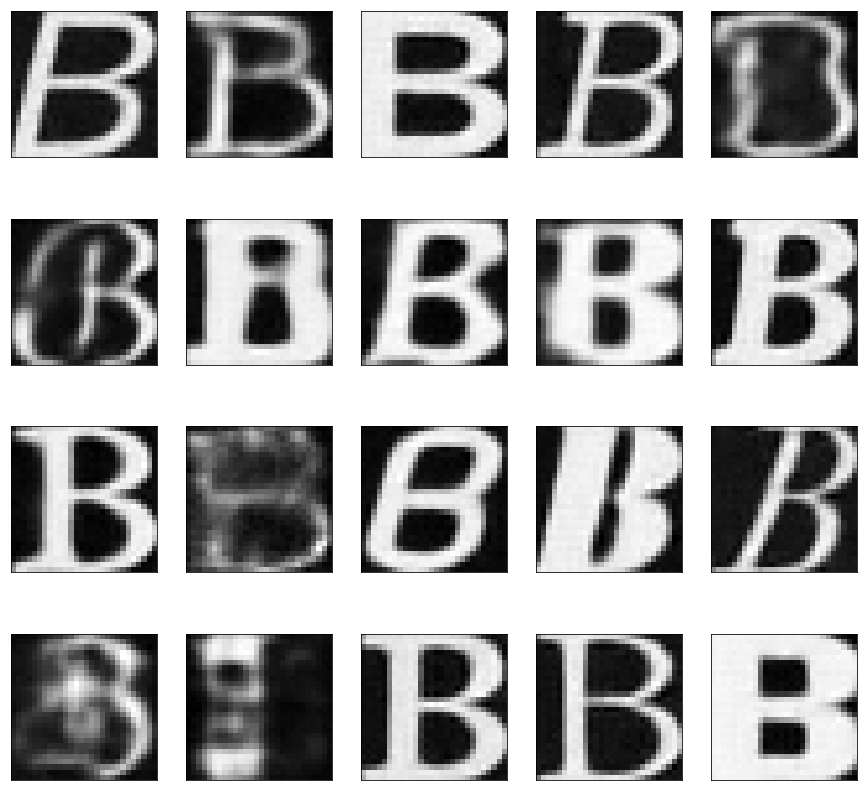

In [59]:
#st = np.random.choice(styles, 20)
display_letter('B', st)

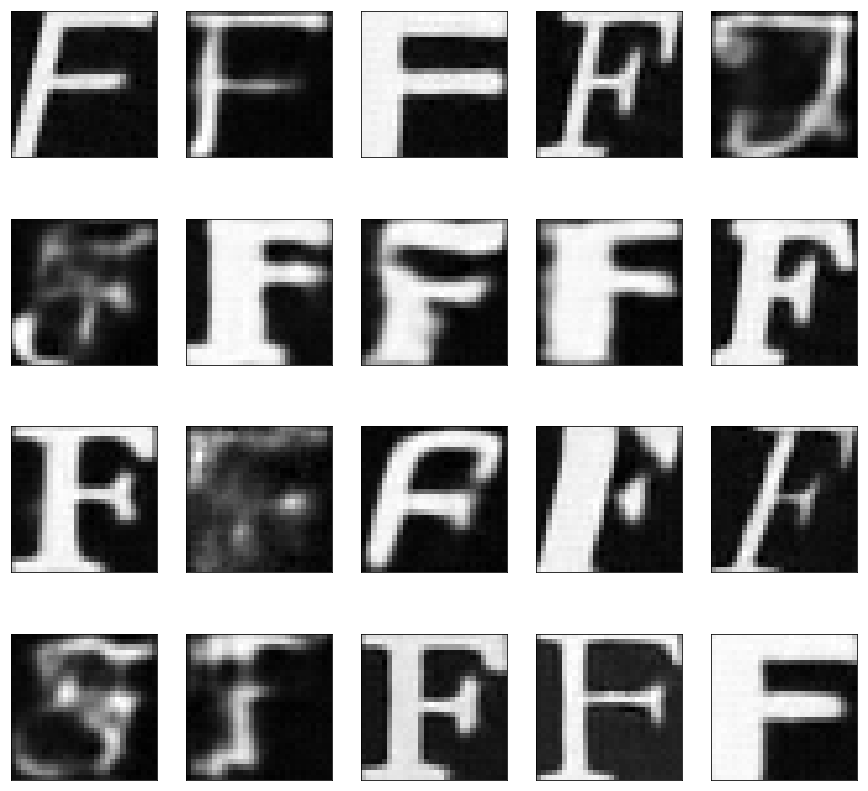

In [60]:
#st = np.random.choice(styles, 20)
display_letter('F', st)

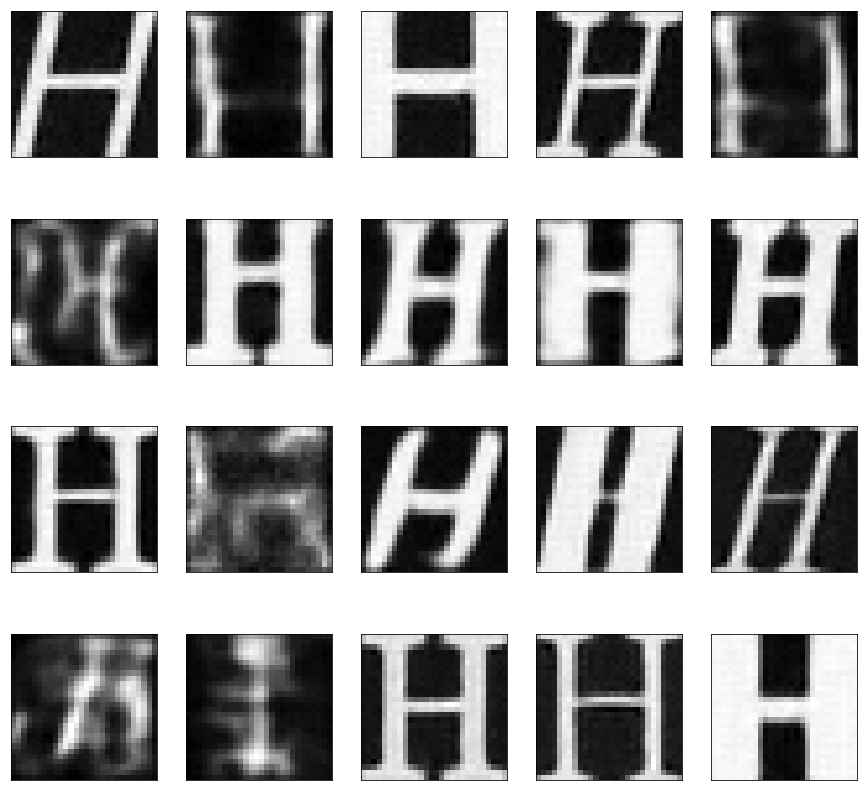

In [61]:
#st = np.random.choice(styles, 20)
display_letter('H', st)

In [74]:
def iterate_minibatches_upd(input0, input2, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(input0))
        np.random.shuffle(indices)
    for start_idx in range(0, len(input0) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield input0[excerpt], input2[excerpt]

In [44]:
def make_noise(batch_size):
    noise = np.random.normal(size=(batch_size, DIM_NOISE)).astype('float32')
    return noise

### VAE for fonts

In [66]:
from GS import *

In [67]:

input_X = T.matrix("X")

input_shape = [None, IMG_SHAPE[0] * IMG_SHAPE[1]]

In [84]:
from lasagne.nonlinearities import rectify, sigmoid, leaky_rectify, tanh
HU_encoder = 500
HU_decoder = 500
dimZ = 250
N = 2

# define the network
# you can start from https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# or another example https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
l_input = lasagne.layers.InputLayer(input_shape, input_var=input_X)
l_enc = lasagne.layers.DenseLayer(l_input, HU_encoder, nonlinearity=leaky_rectify)
l_enc_mu = lasagne.layers.DenseLayer(l_enc, num_units=dimZ, nonlinearity = None)
l_enc_logsigma = lasagne.layers.DenseLayer(l_enc, num_units=dimZ, nonlinearity = None)


l_z = GaussianSampleLayer(l_enc_mu, l_enc_logsigma)
    
l_dec = lasagne.layers.DenseLayer(l_z, HU_decoder, nonlinearity=leaky_rectify)
l_dec_mu = lasagne.layers.DenseLayer(l_dec, num_units=input_shape[1], nonlinearity = tanh)
relu_shift = 10
#l_dec_logsigma = lasagne.layers.DenseLayer(l_dec, num_units=input_shape[1], nonlinearity = lambda a: T.nnet.relu(a +relu_shift) - relu_shift)
l_dec_logsigma = lasagne.layers.DenseLayer(l_dec, num_units=input_shape[1], nonlinearity = None)
l_output = GaussianSampleLayer(l_dec_mu, l_dec_logsigma)


In [85]:
def KL_divergence(mu, logsigma):
    return 0.5 * T.sum(1 + 2*logsigma - T.sqr(mu) - T.exp(2 * logsigma))

def log_likelihood(x, mu, logsigma):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + logsigma) - 0.5 * T.sqr(x - mu) / T.exp(2 * logsigma))

In [88]:
lr_vae = 1e-3

# create prediction variable
prediction_vae = lasagne.layers.get_output(l_output, deterministic = False)

z_mu = lasagne.layers.get_output(l_enc_mu)
z_ls = lasagne.layers.get_output(l_enc_logsigma)
x_mu = lasagne.layers.get_output(l_dec_mu)
x_ls = lasagne.layers.get_output(l_dec_logsigma)
# create loss function
# ...
loss_vae =  - (log_likelihood(input_X, x_mu, x_ls) + KL_divergence(z_mu, z_ls)) / input_shape[1]

# create parameter update expressions
params_vae = lasagne.layers.get_all_params(l_output, trainable=True)
updates_vae = lasagne.updates.adam(loss_vae, params_vae, learning_rate=lr_vae)

# compile training and testing functions
train_fn_1 = theano.function([input_X], loss_vae, updates=updates_vae)
val_fn_1 = theano.function([input_X], loss_vae)
test_fn_1 = theano.function([input_X], prediction_vae)
ll_func = theano.function([input_X], log_likelihood(input_X, x_mu, x_ls))
kl_func = theano.function([input_X], KL_divergence(z_mu, z_ls))

Current loss: -509.845197


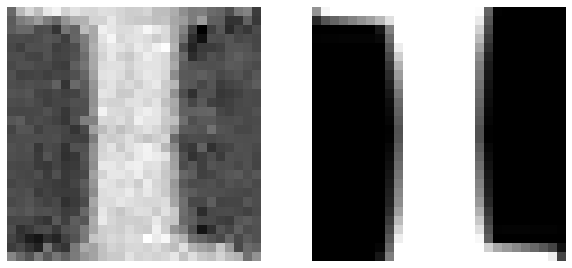

Test loss after epoch 0.000980803784223


In [83]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
from IPython import display
#import seaborn
#lr_vae *= 0.1
# train your autoencoder
# visualize progress in reconstruction and loss decay
num_epochs = 1
loss_history = []
batchsize=200

for epoch in range(num_epochs):
    for letter, batch in iterate_minibatches_upd(x0_train, y_train, batchsize, shuffle=True):
        batch = batch.reshape((batchsize, -1))
        train_loss = (train_fn_1(batch))
        picture = test_fn_1(y_val[0:2].reshape((2, -1)))
        #print(picture.shape)
        # Visualize
        display.clear_output(wait=True)
        if epoch != 0:
            print('Test loss after epoch {}: '.format(epoch), np.mean((pred - y_val.reshape((-1, input_shape[1]))) ** 2))
        print('Current loss: %f' % train_loss)
        plt.figure(figsize=(10, 10))
        plt.subplot(1,2,1)
        plt.imshow(picture[1].reshape(IMG_SHAPE), cmap="gray", interpolation=None)
        plt.xticks(())
        plt.yticks(())
        plt.subplot(1, 2, 2)
        plt.imshow(y_val[1,0,:,:], cmap="gray", interpolation=None)
        plt.xticks(())
        plt.yticks(())
        plt.show()
    pred = test_fn_1(y_val.reshape((-1, input_shape[1])))
    print('Test loss after epoch', np.mean((pred - y_val.reshape((-1, input_shape[1]))) ** 2))


In [82]:
###### the following code is for saving intermediate positive results

import pickle
all_params = lasagne.layers.get_all_param_values(l_output, trainable=True)
output = open('mm2_vae.pkl', "wb")
pickle.dump(all_params, output)
output.close()
#updates = lasagne.updates.adam(loss, params, learning_rate=0.01)
#train_fn = theano.function([input_X], loss, updates=updates)
#lasagne.layers.set_all_param_values(l_output)

#### Let's play with vae

In [89]:
Data = []

labels = []

for letter in classes:
    for path in os.listdir(os.path.join('./notMNIST_small/', letter)):
        path0 = os.path.join('./notMNIST_small/', letter, path)
        try:
            Data.append(imresize(imread(path0),IMG_SHAPE))
        except:
            print("failed: {}".format(path0))
        else: 
            labels.append([dicttt[letter], dictt[path]])

Data = np.stack(Data)[:,None]
Data = Data.astype(np.float32)
Data = (Data - np.mean(Data))/np.std(Data)/16.
labels = np.array(labels)

failed: ./notMNIST_small/A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
failed: ./notMNIST_small/F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


([], <a list of 0 Text yticklabel objects>)

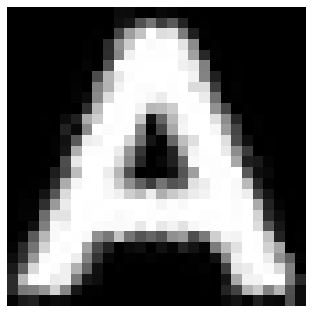

In [92]:
plt.imshow(Data[0,0], cmap="gray", interpolation=None)
plt.xticks(())
plt.yticks(())

([], <a list of 0 Text yticklabel objects>)

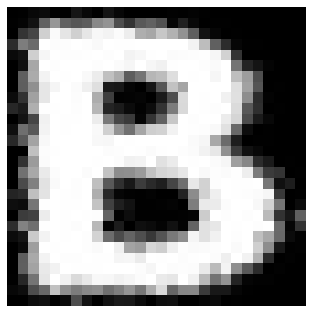

In [95]:
plt.imshow(Data[1872,0], cmap="gray", interpolation=None)
plt.xticks(())
plt.yticks(())

In [138]:
z_vae = lasagne.layers.get_output(l_z, deterministic=False)
get_z = theano.function([input_X], z_vae)

In [139]:
let_train = np.argwhere(x0_train == 1)[:,1]

In [105]:
st_train = np.argwhere(x1_train == 1)[:, 1]

In [126]:
idx10 = np.argwhere(st_train == 10)[:,0]

In [188]:
idx35 = np.argwhere(st_train == 35)[:,0]

In [191]:
z_st35 = get_z(y_train[idx35].reshape((len(idx35), -1))).mean(axis = 0)
z_st10 = get_z(y_train[idx10].reshape((len(idx10), -1))).mean(axis = 0)

In [192]:
generated_x = lasagne.layers.get_output(l_output, {l_z: z_vae - z_st35 + z_st10}) 
change_font = theano.function([input_X], generated_x)

In [193]:
picture = change_font(y_train[idx35].reshape((len(idx35), -1)))

([], <a list of 0 Text yticklabel objects>)

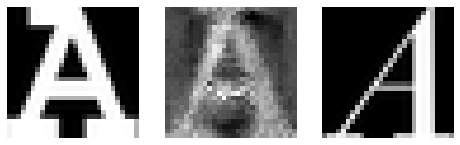

In [206]:
plt.subplot(1, 3, 1)
plt.imshow(y_train[idx35[2], 0], cmap = "gray", interpolation=None)


plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
plt.imshow(picture[2].reshape(IMG_SHAPE), cmap = "gray", interpolation=None)

plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 3)
plt.imshow(y_train[idx10[9], 0], cmap = "gray", interpolation=None)

plt.xticks(())
plt.yticks(())